In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torch.distributed as dist
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import numpy as np
import re

from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

sys.path.append('../dino')
import utils

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

In [2]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

### Create ImageNet validation dataset

In [3]:
class ReturnIndexDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, idx

In [4]:
transform = transforms.Compose([
        transforms.Resize(256, interpolation=3),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

data_path = '/datasets01/imagenet_full_size/061417/'

dataset_train = ReturnIndexDataset(os.path.join(data_path, "train"), transform=transform)
dataset_val = ReturnIndexDataset(os.path.join(data_path, "val"), transform=transform)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=256,
    num_workers=10,
    pin_memory=True,
    drop_last=False,
)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=256,
    num_workers=10,
    pin_memory=True,
    drop_last=False,
)
print(f"Data loaded with {len(dataset_train)} train and {len(dataset_val)} val imgs.")


/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Data loaded with 1281167 train and 50000 val imgs.


### Load pre-trained DINO, Moco-v3, MAE

In [4]:
vitb16_dino = get_model('DINO', 'pretrained')
vitb16_mae = get_model('MAE', 'pretrained')
vitb16_mocov3 = get_model('MoCo-V3', 'pretrained')

Using cache found in /private/home/sshkhr/.cache/torch/hub/facebookresearch_dino_main
/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
for name, module in vitb16_mocov3.named_modules():
        print(name, type(module))

 <class 'vits.VisionTransformerMoCo'>
patch_embed <class 'timm.models.layers.patch_embed.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
patch_embed.norm <class 'torch.nn.modules.linear.Identity'>
pos_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks <class 'torch.nn.modules.container.Sequential'>
blocks.0 <class 'timm.models.vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'timm.models.vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.ls1 <class 'torch.nn.modules.linear.Identity'>
blocks.0.drop_path1 <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'timm.models.layers.mlp.Mlp'>


In [6]:
for name, module in vitb16_dino.named_modules():
        print(name, type(module))

 <class 'vision_transformer.VisionTransformer'>
patch_embed <class 'vision_transformer.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
pos_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks <class 'torch.nn.modules.container.ModuleList'>
blocks.0 <class 'vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.drop_path <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'vision_transformer.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linear.Linear'>
blocks.0.mlp.act <class 'torch.nn.modules.activation.GELU'>
blocks.0.mlp.fc2 <class 'torc

In [7]:
for name, module in vitb16_mae.named_modules():
        print(name, type(module))

 <class 'models_mae.MaskedAutoencoderViT'>
patch_embed <class 'timm.models.layers.patch_embed.PatchEmbed'>
patch_embed.proj <class 'torch.nn.modules.conv.Conv2d'>
patch_embed.norm <class 'torch.nn.modules.linear.Identity'>
blocks <class 'torch.nn.modules.container.ModuleList'>
blocks.0 <class 'timm.models.vision_transformer.Block'>
blocks.0.norm1 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.attn <class 'timm.models.vision_transformer.Attention'>
blocks.0.attn.qkv <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.attn_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.attn.proj <class 'torch.nn.modules.linear.Linear'>
blocks.0.attn.proj_drop <class 'torch.nn.modules.dropout.Dropout'>
blocks.0.ls1 <class 'torch.nn.modules.linear.Identity'>
blocks.0.drop_path1 <class 'torch.nn.modules.linear.Identity'>
blocks.0.norm2 <class 'torch.nn.modules.normalization.LayerNorm'>
blocks.0.mlp <class 'timm.models.layers.mlp.Mlp'>
blocks.0.mlp.fc1 <class 'torch.nn.modules.linea

In [8]:
vitb16_dino.to(DEVICE)
vitb16_mae.to(DEVICE)
vitb16_mocov3.to(DEVICE)

#vitb16_dino = torch.nn.DataParallel(vitb16_dino)
#vitb16_mae = torch.nn.DataParallel(vitb16_mae)
#vitb16_mocov3 = torch.nn.DataParallel(vitb16_mocov3)

vitb16_dino.eval()
vitb16_mae.eval()
vitb16_mocov3.eval()

VisionTransformerMoCo(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (ls2): Identity()
 

In [9]:
import fnmatch

In [10]:
models = [vitb16_mae, vitb16_dino, vitb16_mocov3]

for model in models:
    for name, module in model.named_modules():
        if fnmatch.fnmatch(name, 'blocks.*') and not fnmatch.fnmatch(name, 'blocks.*.*'):
            print(name)

blocks.0
blocks.1
blocks.2
blocks.3
blocks.4
blocks.5
blocks.6
blocks.7
blocks.8
blocks.9
blocks.10
blocks.11
blocks.0
blocks.1
blocks.2
blocks.3
blocks.4
blocks.5
blocks.6
blocks.7
blocks.8
blocks.9
blocks.10
blocks.11
blocks.0
blocks.1
blocks.2
blocks.3
blocks.4
blocks.5
blocks.6
blocks.7
blocks.8
blocks.9
blocks.10
blocks.11


In [11]:
summary(vitb16_mocov3, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
         Identity-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 19

In [12]:
def getActivation(name, cache):

    cache.setdefault('CLS_feats', {})
    cache.setdefault('GAP_feats', {})
    cache.setdefault('GAP_WO_CLS_feats', {})

    # the hook signature
    def hook(model, input, output):
            print(cache)

            cls_features = output[:, 0].detach().cpu()
            gap_features = output.mean(dim=-2).detach().cpu()
            gap_features_wo_cls = output[:, 1:].mean(dim=-2).detach().cpu()
            
            cache['CLS_feats'].setdefault(name, []).append(cls_features)
            cache['GAP_feats'].setdefault(name, []).append(gap_features)
            cache['GAP_WO_CLS_feats'].setdefault(name, []).append(gap_features_wo_cls)
    return hook

In [13]:
@torch.no_grad()
def extract_features(model, data_loader, use_cuda=True, multiscale=False):
        metric_logger = utils.MetricLogger(delimiter="  ")

        features = None

        cache = {}
        hooks = []
        intermediate_features = {}

        if use_cuda:
            model = model.cuda()
        
        model.eval()

        indexes = []

        for name, module in model.named_modules():
            if fnmatch.fnmatch(name, 'blocks.*') and not fnmatch.fnmatch(name, 'blocks.*.*'):
                hook = module.register_forward_hook(getActivation(name, cache))
                hooks.append(hook)

        for samples, index in metric_logger.log_every(data_loader, 10):
            samples = samples.cuda(non_blocking=True)
            index = index.cuda(non_blocking=True)
            temp = model(samples)
            feats = temp.clone()

            if features is None:
                features = torch.zeros(len(data_loader.dataset), feats.shape[-1])

            #if use_cuda:
            #    features = features.cuda()

            if use_cuda:
                features.index_copy_(0, index.cpu(), feats.cpu())
            else:
                features.index_copy_(0, index.cpu(), feats.cpu())

            indexes.append(index.cpu())

        for hook in hooks:
            hook.remove()

        for layer in cache:
            intermediate_features[layer] = torch.zeros(len(data_loader.dataset), cache[layer][0].shape[-1])

            for index, batch_feat in zip(indexes, cache[layer]):
                intermediate_features[layer].index_copy_(0, index, batch_feat)
                
        return features, intermediate_features

In [14]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5


### Validate on ImageNet test set

In [15]:
def kNN_probe(model, name):
    # need to extract features !
    train_features, train_cache  = extract_features(model, data_loader_train)
    print("Extracting features for val set...")
    test_features, test_cache = extract_features(model, data_loader_val)

    print(train_features.shape)
    print(test_features.shape)

    for layer in train_cache:
        print(layer, train_cache[layer].shape)

    for layer in test_cache:
        print(layer, test_cache[layer].shape)

    train_features = torch.nn.functional.normalize(train_features, dim=1, p=2)
    test_features = torch.nn.functional.normalize(test_features, dim=1, p=2)

    for layer in test_cache:
        train_cache[layer] = torch.nn.functional.normalize(train_cache[layer], dim=1, p=2)
        test_cache[layer] = torch.nn.functional.normalize(test_cache[layer], dim=1, p=2)

    train_labels = torch.tensor([s[-1] for s in dataset_train.samples[:50000]]).long()
    test_labels = torch.tensor([s[-1] for s in dataset_val.samples]).long()
    
    # save features and labels
    folder_name = os.path.join('../features', name)
    
    torch.save(train_features.cpu(), folder_name + "/" + "trainfeat.pth")
    torch.save(test_features.cpu(), folder_name + "/" + "testfeat.pth")
    torch.save(train_labels.cpu(), folder_name + "/" + "trainlabels.pth")
    torch.save(test_labels.cpu(), folder_name + "/" + "testlabels.pth")

    pickle.dump(train_cache, open(folder_name + "/" + "traincache.pkl", "wb" ))
    pickle.dump(test_cache, open(folder_name + "/" + "testcache.pkl", "wb" ))

    train_features = train_features.cuda()
    test_features = test_features.cuda()
    train_labels = train_labels.cuda()
    test_labels = test_labels.cuda()

    print(train_features.shape, test_features.shape, train_labels.shape, test_labels.shape)

    print("Features are ready!\nStart the k-NN classification.")
    for k in [20]:
        top1, top5 = knn_classifier(train_features, train_labels,
            test_features, test_labels, k, 0.07)
        print(name+" "+f"{k}-NN classifier result: Top1: {top1}, Top5: {top5}")

    for agg in test_cache:
        for layer in agg:
            top1, top5 = knn_classifier(train_cache[layer], train_labels.cpu(),
                test_cache[layer], test_labels.cpu(), k, 0.07)
            print(name+" "+agg+" "+layer+f" {k}-NN classifier result: Top1: {top1}, Top5: {top5}")

    return top1, top5, train_cache, test_cache


In [ ]:
moco_results_top1, moco_results_top5, moco_cache_train, moco_cache_test = kNN_probe(vitb16_mocov3, 'MoCo-V3')

In [ ]:
dino_results = kNN_probe(vitb16_dino, 'DINO')

In [ ]:
mae_results = kNN_probe(vitb16_mae, 'MAE')

### Plots

In [5]:
slurm_job = "63044823"

In [6]:
import subprocess

In [7]:
def tail(f, n, offset=0):
    proc = subprocess.Popen(['tail', '-n', f'{n + offset}', f], stdout=subprocess.PIPE)
    lines = proc.stdout.readlines()
    return lines[:-1]

In [8]:
results = {}

for i in [0, 1, 2]:
    log_file = "knn-logs/" + slurm_job + "_" + str(i) + "_0_log.out"
    print(log_file)
    results[i] = tail(log_file, 13, 1)
    results[i] = results[i][1:] + results[i][0:1]

slurm_job = "65204763"

for i in [1]:
    log_file = "knn-logs/" + slurm_job + "_0_log.out"
    print(log_file)
    results[i] = tail(log_file, 13, 1)
    results[i] = results[i][1:] + results[i][0:1]

knn-logs/63044823_0_0_log.out
knn-logs/63044823_1_0_log.out
knn-logs/63044823_2_0_log.out
knn-logs/65204763_0_log.out


In [9]:
accuracy_scores = {}

for i in [0, 1, 2]:
    key = results[i][0].split(b' ')[0].decode("utf-8") 

    print(key)

    blocks = [lines.split(b' ')[1].split(b'.')[-1].decode("utf-8") for lines in results[i]]
    blocks[-1] = '12' # Denoting linear probe as last 'block'
    blocks = [int(x) for x in blocks]

    top_1 = [float(lines.split(b' ')[-3].split(b',')[0].decode("utf-8")) for lines in results[i]]
    top_5 = [float(lines.split(b' ')[-1].split(b'\n')[0].decode("utf-8")) for lines in results[i]]

    model = [key]*len(top_1)
    
    accuracy_scores[key] = pd.DataFrame(list(zip(blocks, top_1, top_5, model)),
              columns=['Block','Top-1', 'Top-5', 'Model'])
    

MoCo-V3


ValueError: invalid literal for int() with base 10: 'GAP_feats'

In [ ]:
df = pd.concat(list(accuracy_scores.values()), ignore_index=True)

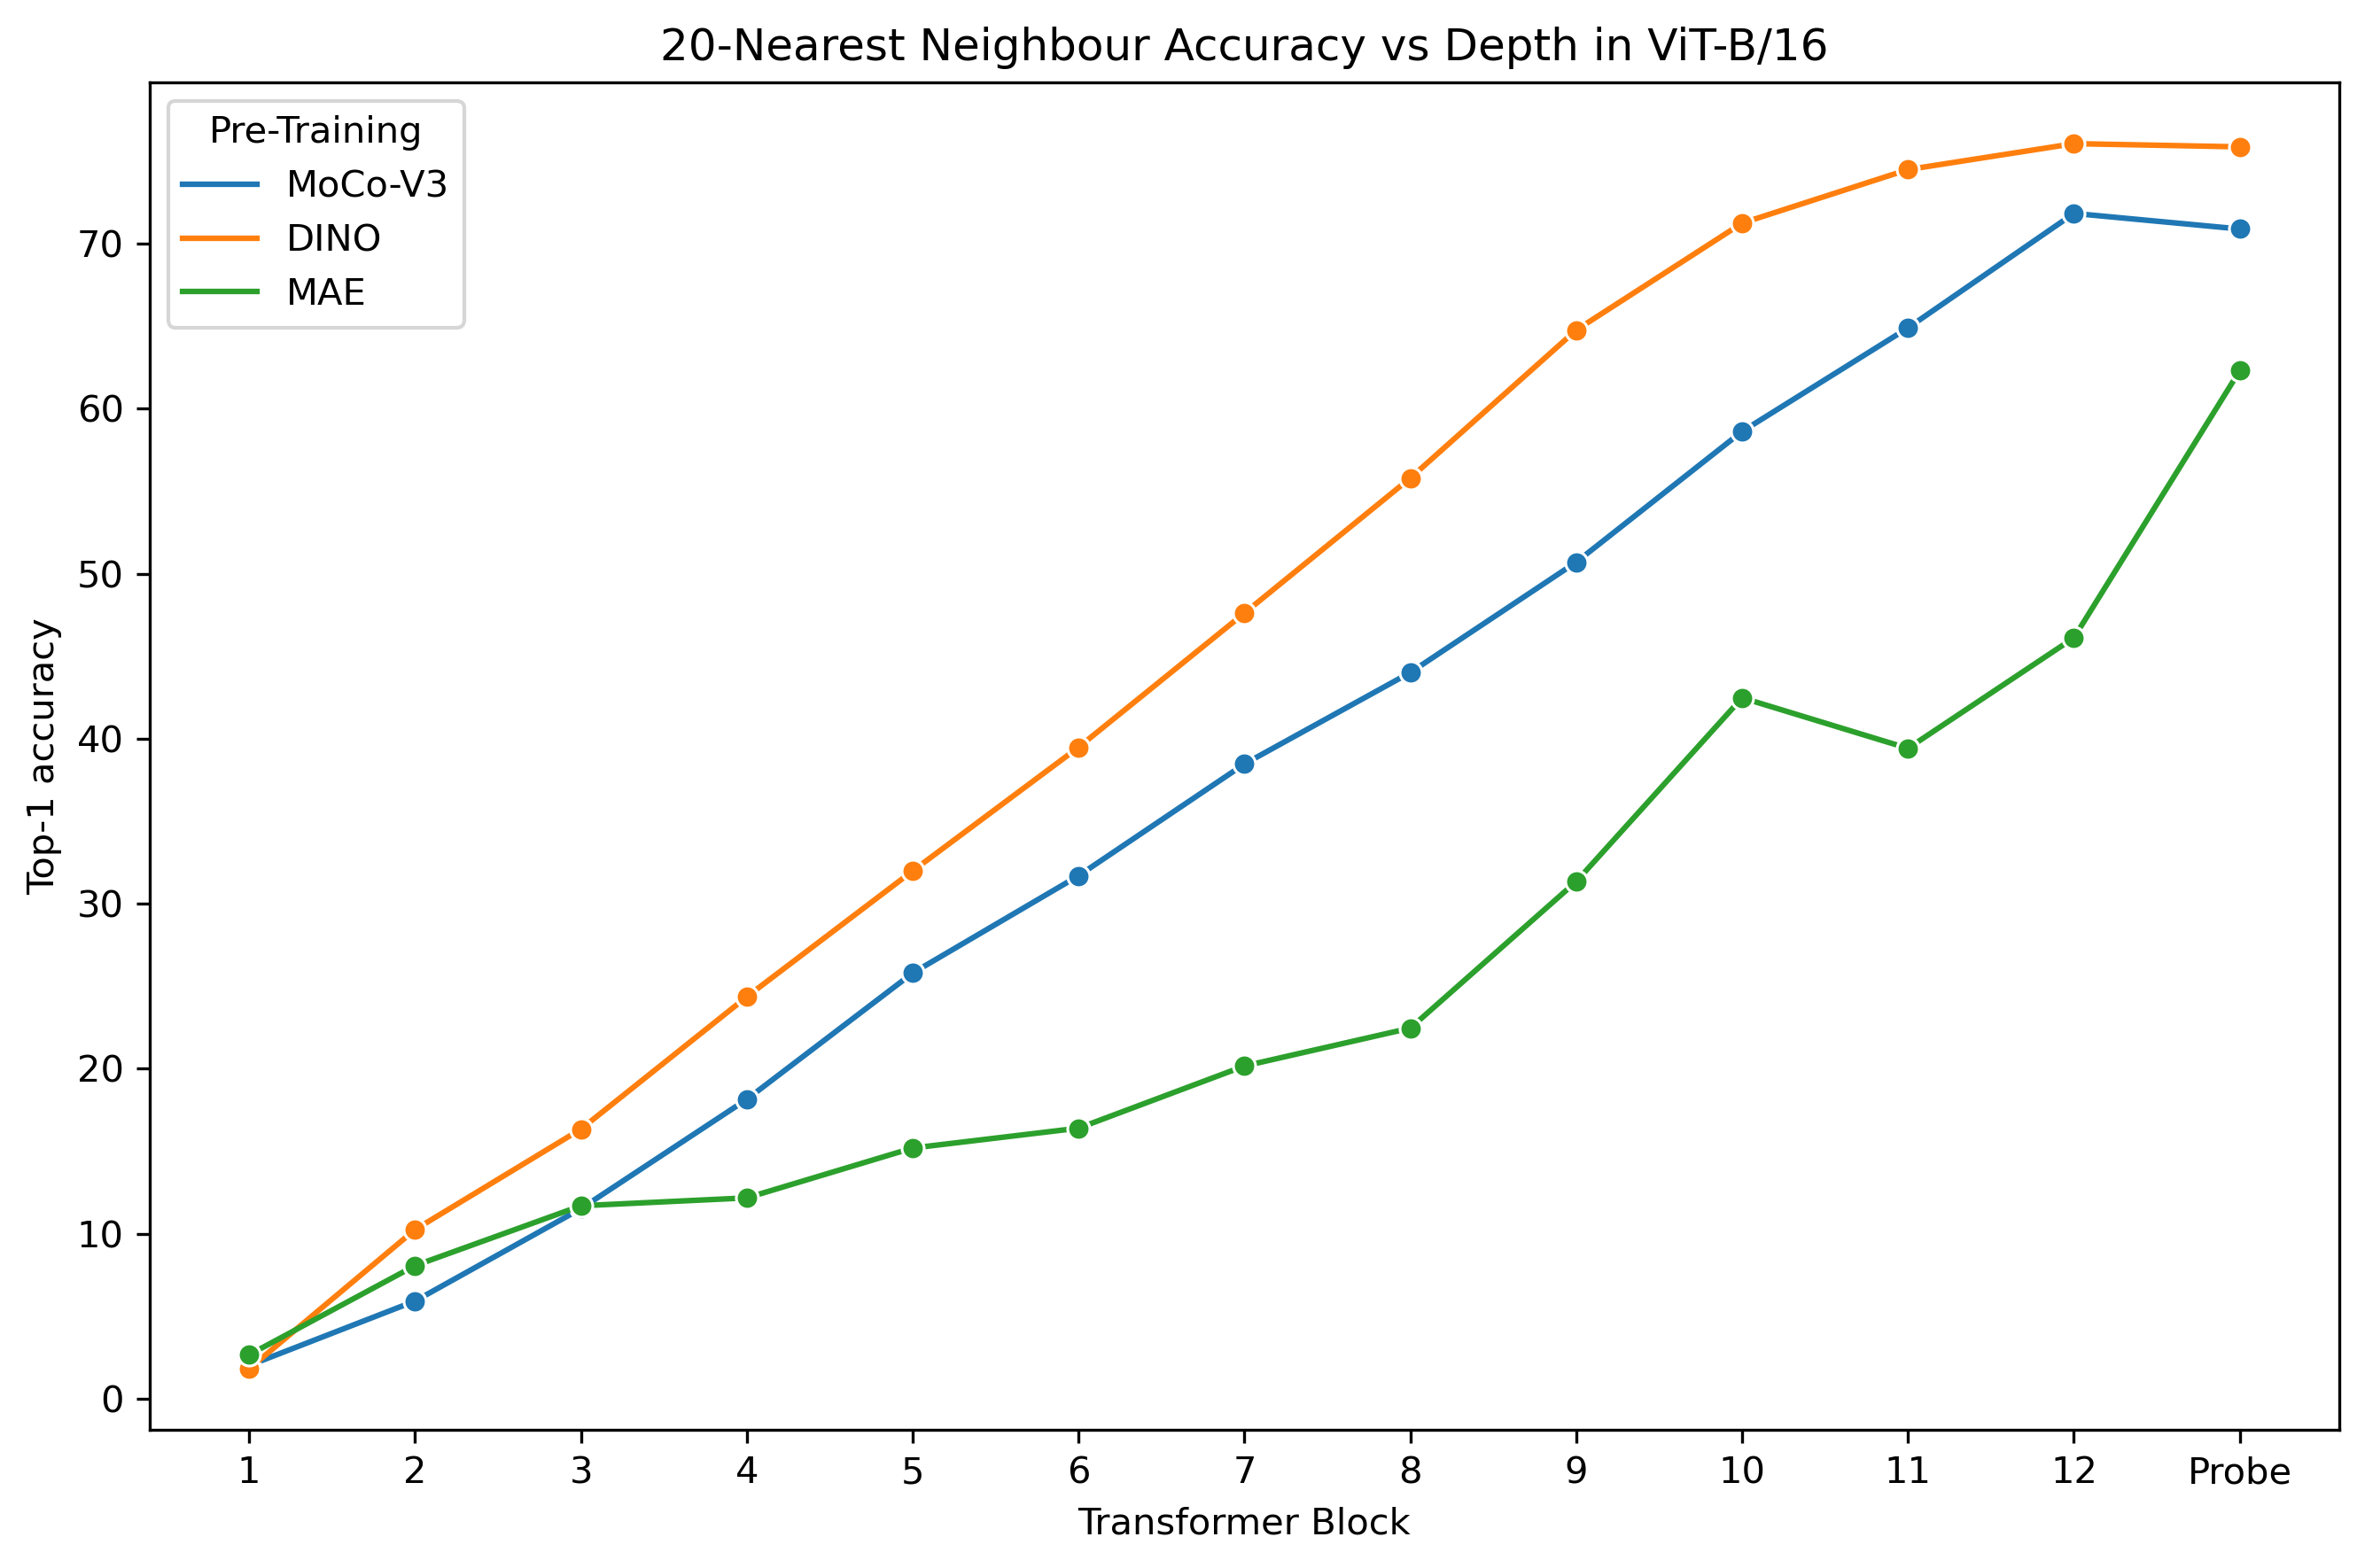

In [ ]:
fig_dir = '../figures/kNN/'

fig, ax = plt.subplots(figsize=(9, 6), dpi=300, sharey=True)

ax.set_xticks(range(0, 13, 1))
ax.set_xticklabels([str(x) for x in range(1, 14, 1)])

f = sns.lineplot(x="Block", y="Top-1", hue="Model", data=df, marker='o', ax=ax)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = 'Probe'

ax.set_xticklabels(labels)

plt.xlabel("Transformer Block")
plt.ylabel("Top-1 accuracy")

plt.title("20-Nearest Neighbour Accuracy vs Depth in ViT-B/16")
plt.legend(title='Pre-Training', loc='upper left')
plt.tight_layout()
plt.show()

fig.savefig(fig_dir+'top-1.png')

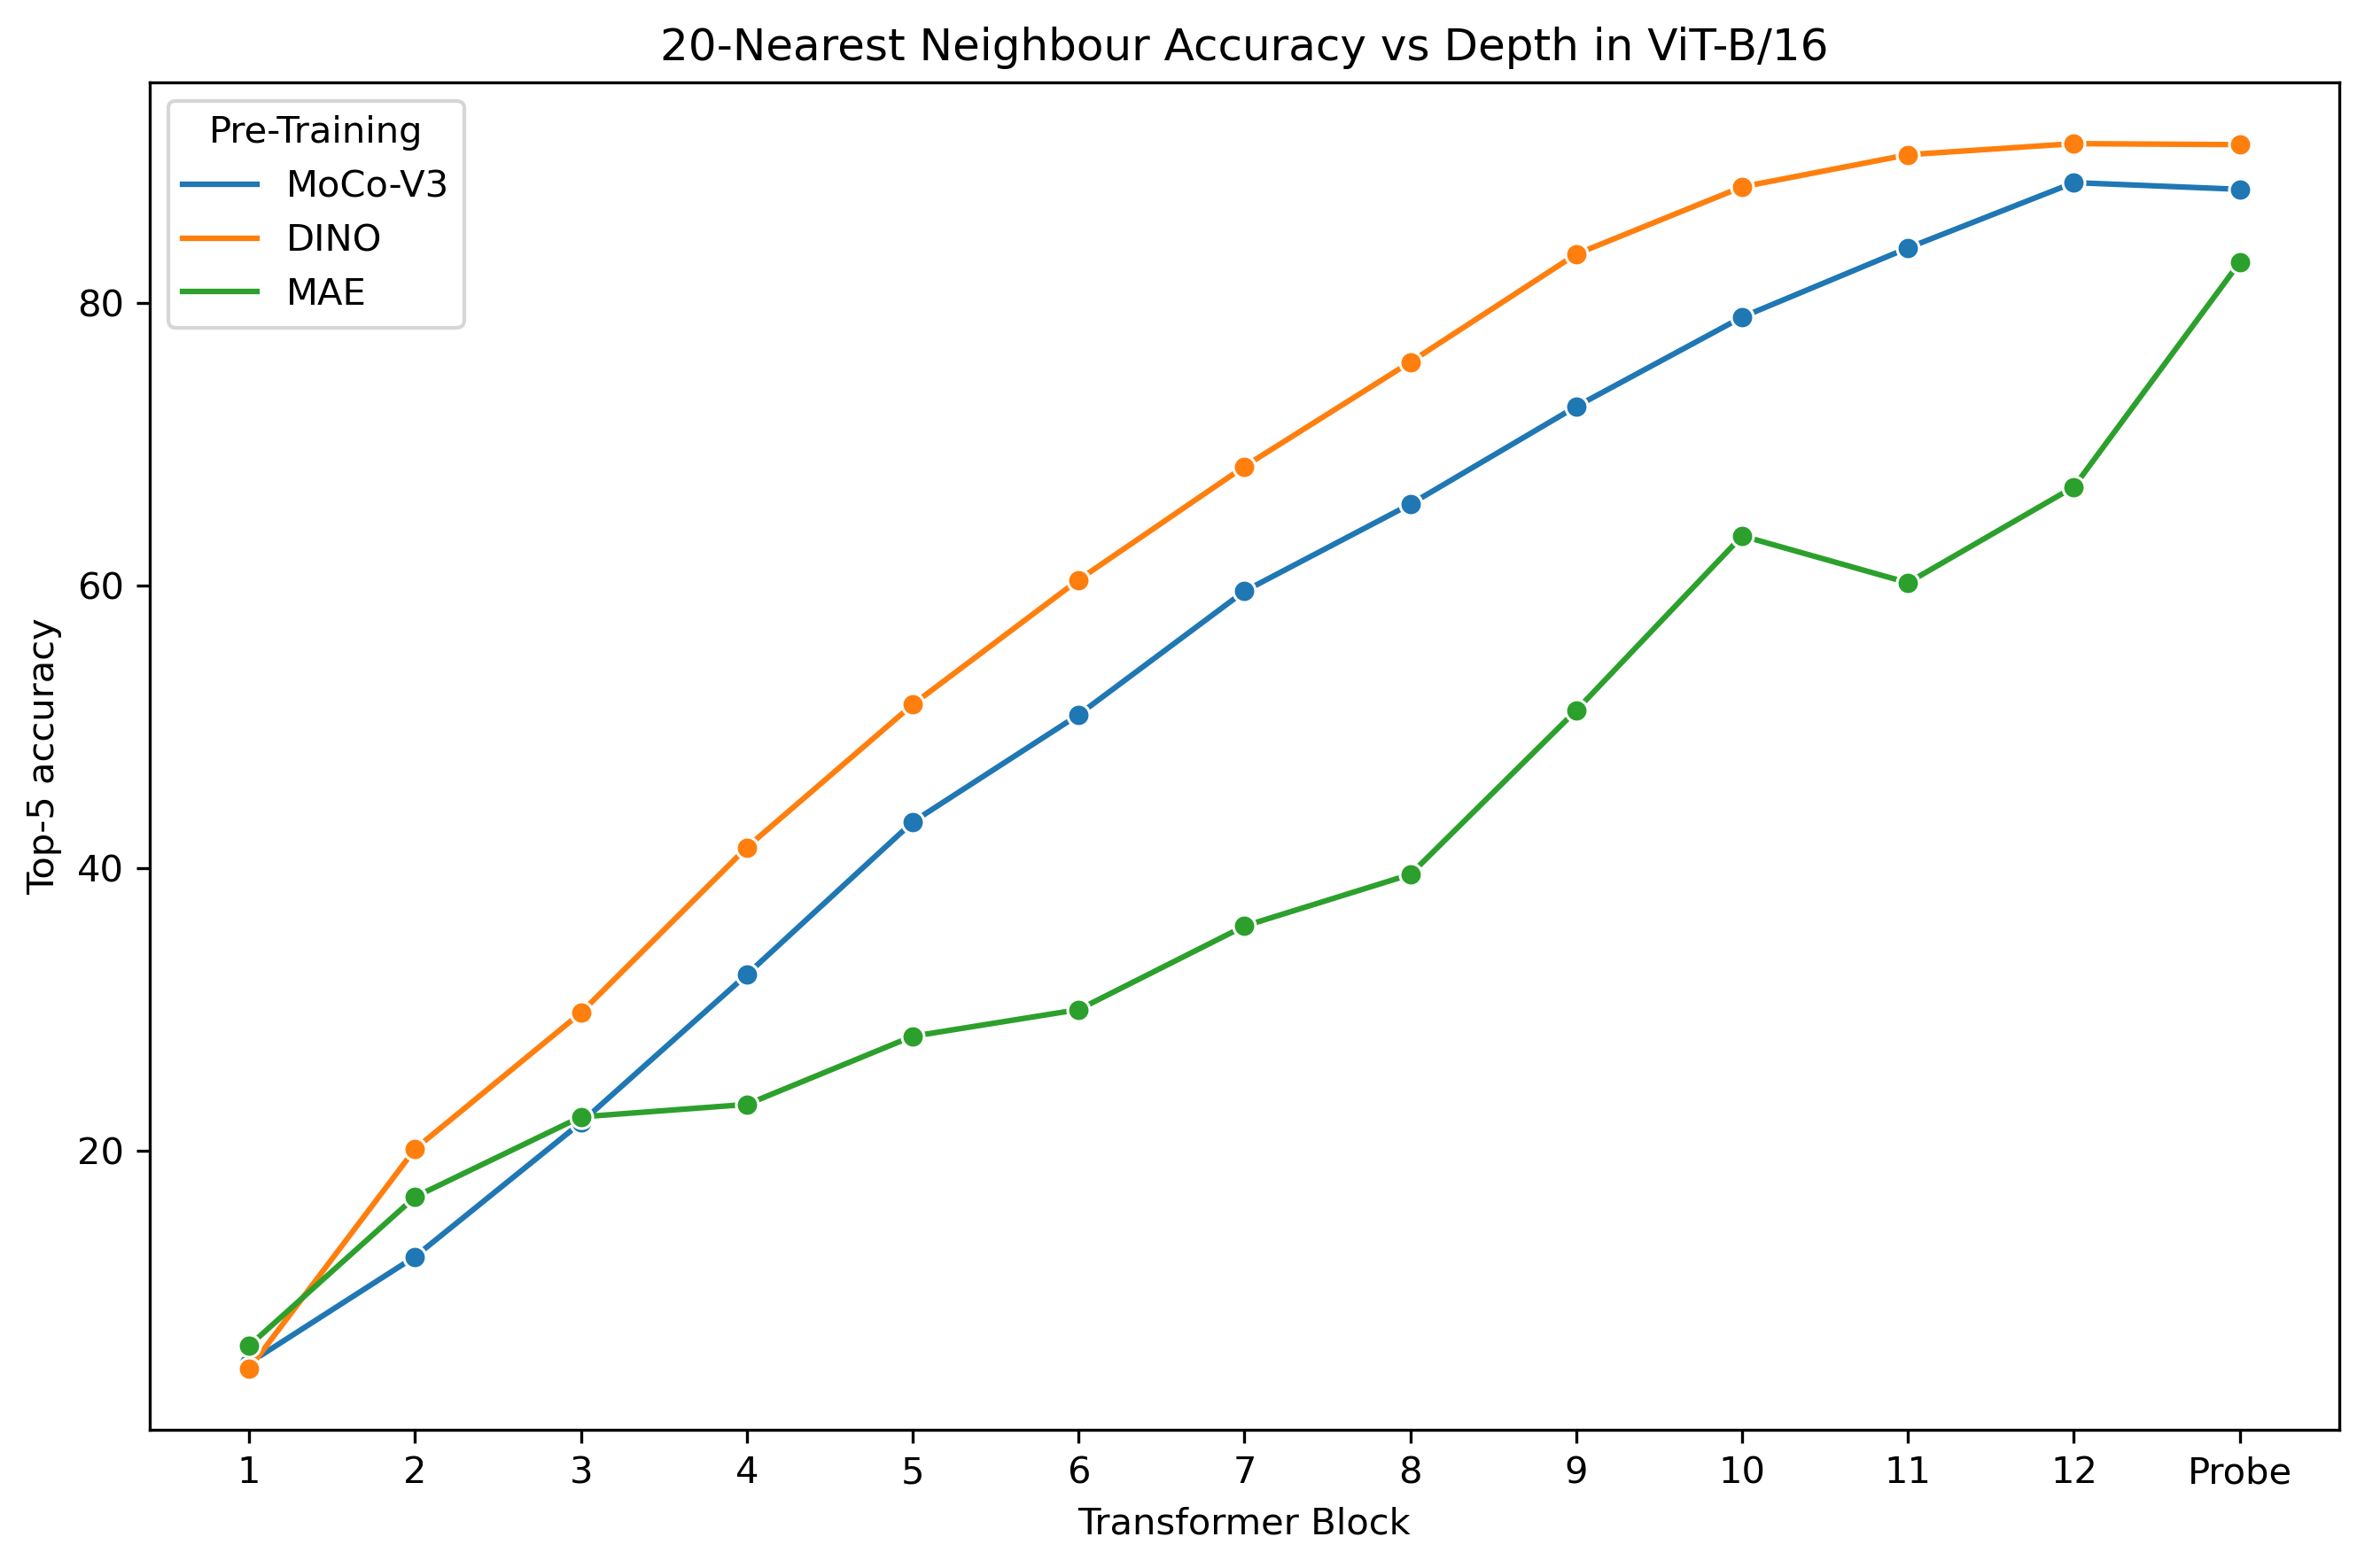

In [ ]:
fig_dir = '../figures/kNN/'

fig, ax = plt.subplots(figsize=(9, 6), dpi=300, sharey=True)

ax.set_xticks(range(0, 13, 1))
ax.set_xticklabels([str(x) for x in range(1, 14, 1)])

f = sns.lineplot(x="Block", y="Top-5", hue="Model", data=df, marker='o', ax=ax)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[-1] = 'Probe'

ax.set_xticklabels(labels)

plt.xlabel("Transformer Block")
plt.ylabel("Top-5 accuracy")

plt.title("20-Nearest Neighbour Accuracy vs Depth in ViT-B/16")
plt.legend(title='Pre-Training', loc='upper left')
plt.tight_layout()
plt.show()

fig.savefig(fig_dir+'top-5.png')

### Detailed plots

In [3]:
log_dir = "../features/"

models = ['MAE', 'MoCo-V3', 'DINO']
modes = ['linear', 'finetuned']

results = {}

for model in models:
    results[model] = {}
    for mode in modes:
        file = log_dir + model + "/" + mode + "/knn_results.csv"
        results[model][mode] = pd.read_csv(file, index_col=0)

In [4]:
import textwrap

In [30]:
def get_probe_fig_single(results, models, agg_mode='CLS_feats', top_n='top-5', training='linear'):

    fig_dir = '../figures/kNN/'

    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=500)

    axis.set_xticks(range(0, 13, 1))
    axis.set_xticklabels([str(x) for x in range(1, 14, 1)])

    
    for model in models:
        f = sns.lineplot(x="ViT_block", y=top_n, data=results[model][training].loc[(results[model][training]['agg_mode'] == agg_mode) | (results[model][training]['agg_mode'] == 'linear')], marker='o', linewidth=2, ax=axis, label=model)

    plt.xlabel("Transformer Block", fontsize=20, fontweight="bold")
    axis.set_ylabel(top_n.capitalize() + " accuracy", fontsize=20, fontweight="bold")

    labels = [item.get_text() for item in axis.get_xticklabels()]
    labels[-1] = textwrap.fill('Probe', 5)

    axis.set_xticklabels(labels, size=20)

    agg = agg_mode.split('_feats')[0]

    fig.suptitle(f"20-NN Accuracy on ImageNet vs Depth", fontsize=22, fontweight="bold")# in ViT-B/16 using {agg} features")
    
    axis.legend(loc='upper left', prop=dict(weight='bold', size=18))
    #leg = axis.legend()
    #leg.set_title('Pre-Training', prop={'size':18})
    
    plt.yticks(np.arange(10, 101, 10))
    plt.xticks(rotation=-45)

    for item in ([axis.xaxis.label, axis.yaxis.label] +
             axis.get_xticklabels() + axis.get_yticklabels()):
        item.set_fontsize(20)
        item.set_weight('bold')

    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+agg+'_'+training+'_'+top_n+'-poster.png', dpi=500)

In [29]:
def get_probe_figs(results, models, agg_mode='CLS_feats', top_n='top-5'):

    fig_dir = '../figures/kNN/'

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), dpi=300)

    for axis in ax:
        axis.set_xticks(range(0, 13, 1))
        axis.set_xticklabels([str(x) for x in range(1, 14, 1)])

    
    for model in models:
        f = sns.lineplot(x="ViT_block", y=top_n, data=results[model]['linear'].loc[(results[model]['linear']['agg_mode'] == agg_mode) | (results[model]['linear']['agg_mode'] == 'linear')], marker='o', linewidth=1.5, ax=ax[0], label=model)

    for model in models:
        f = sns.lineplot(x="ViT_block", y=top_n, data=results[model]['finetuned'].loc[(results[model]['finetuned']['agg_mode'] == agg_mode) | (results[model]['finetuned']['agg_mode'] == 'linear')], marker='o', linewidth=1.5, ax=ax[1], label=model)

    plt.xlabel("Transformer Block")
    ax[0].set_ylabel(top_n.capitalize() + " accuracy")
    ax[1].set_ylabel(top_n.capitalize() + " accuracy")

    labels = [item.get_text() for item in ax[0].get_xticklabels()]
    labels[-1] = 'Probe'

    ax[0].set_xticklabels(labels, weight='bold', size=16)
    ax[1].set_xticklabels(labels, weight='bold', size=16)

    agg = agg_mode.split('_feats')[0]

    fig.suptitle(f"20-Nearest Neighbour Accuracy vs Depth in ViT-B/16 using {agg} features")

    ax[0].title.set_text('Pre-Trained Model')
    ax[1].title.set_text('Fine-Tuned Model')

    ax[0].legend(title='Pre-Training', loc='upper left')
    ax[1].get_legend().remove()

    plt.tight_layout()
    plt.show()

    fig.savefig(fig_dir+agg+'_'+top_n+'-ssl.pdf')

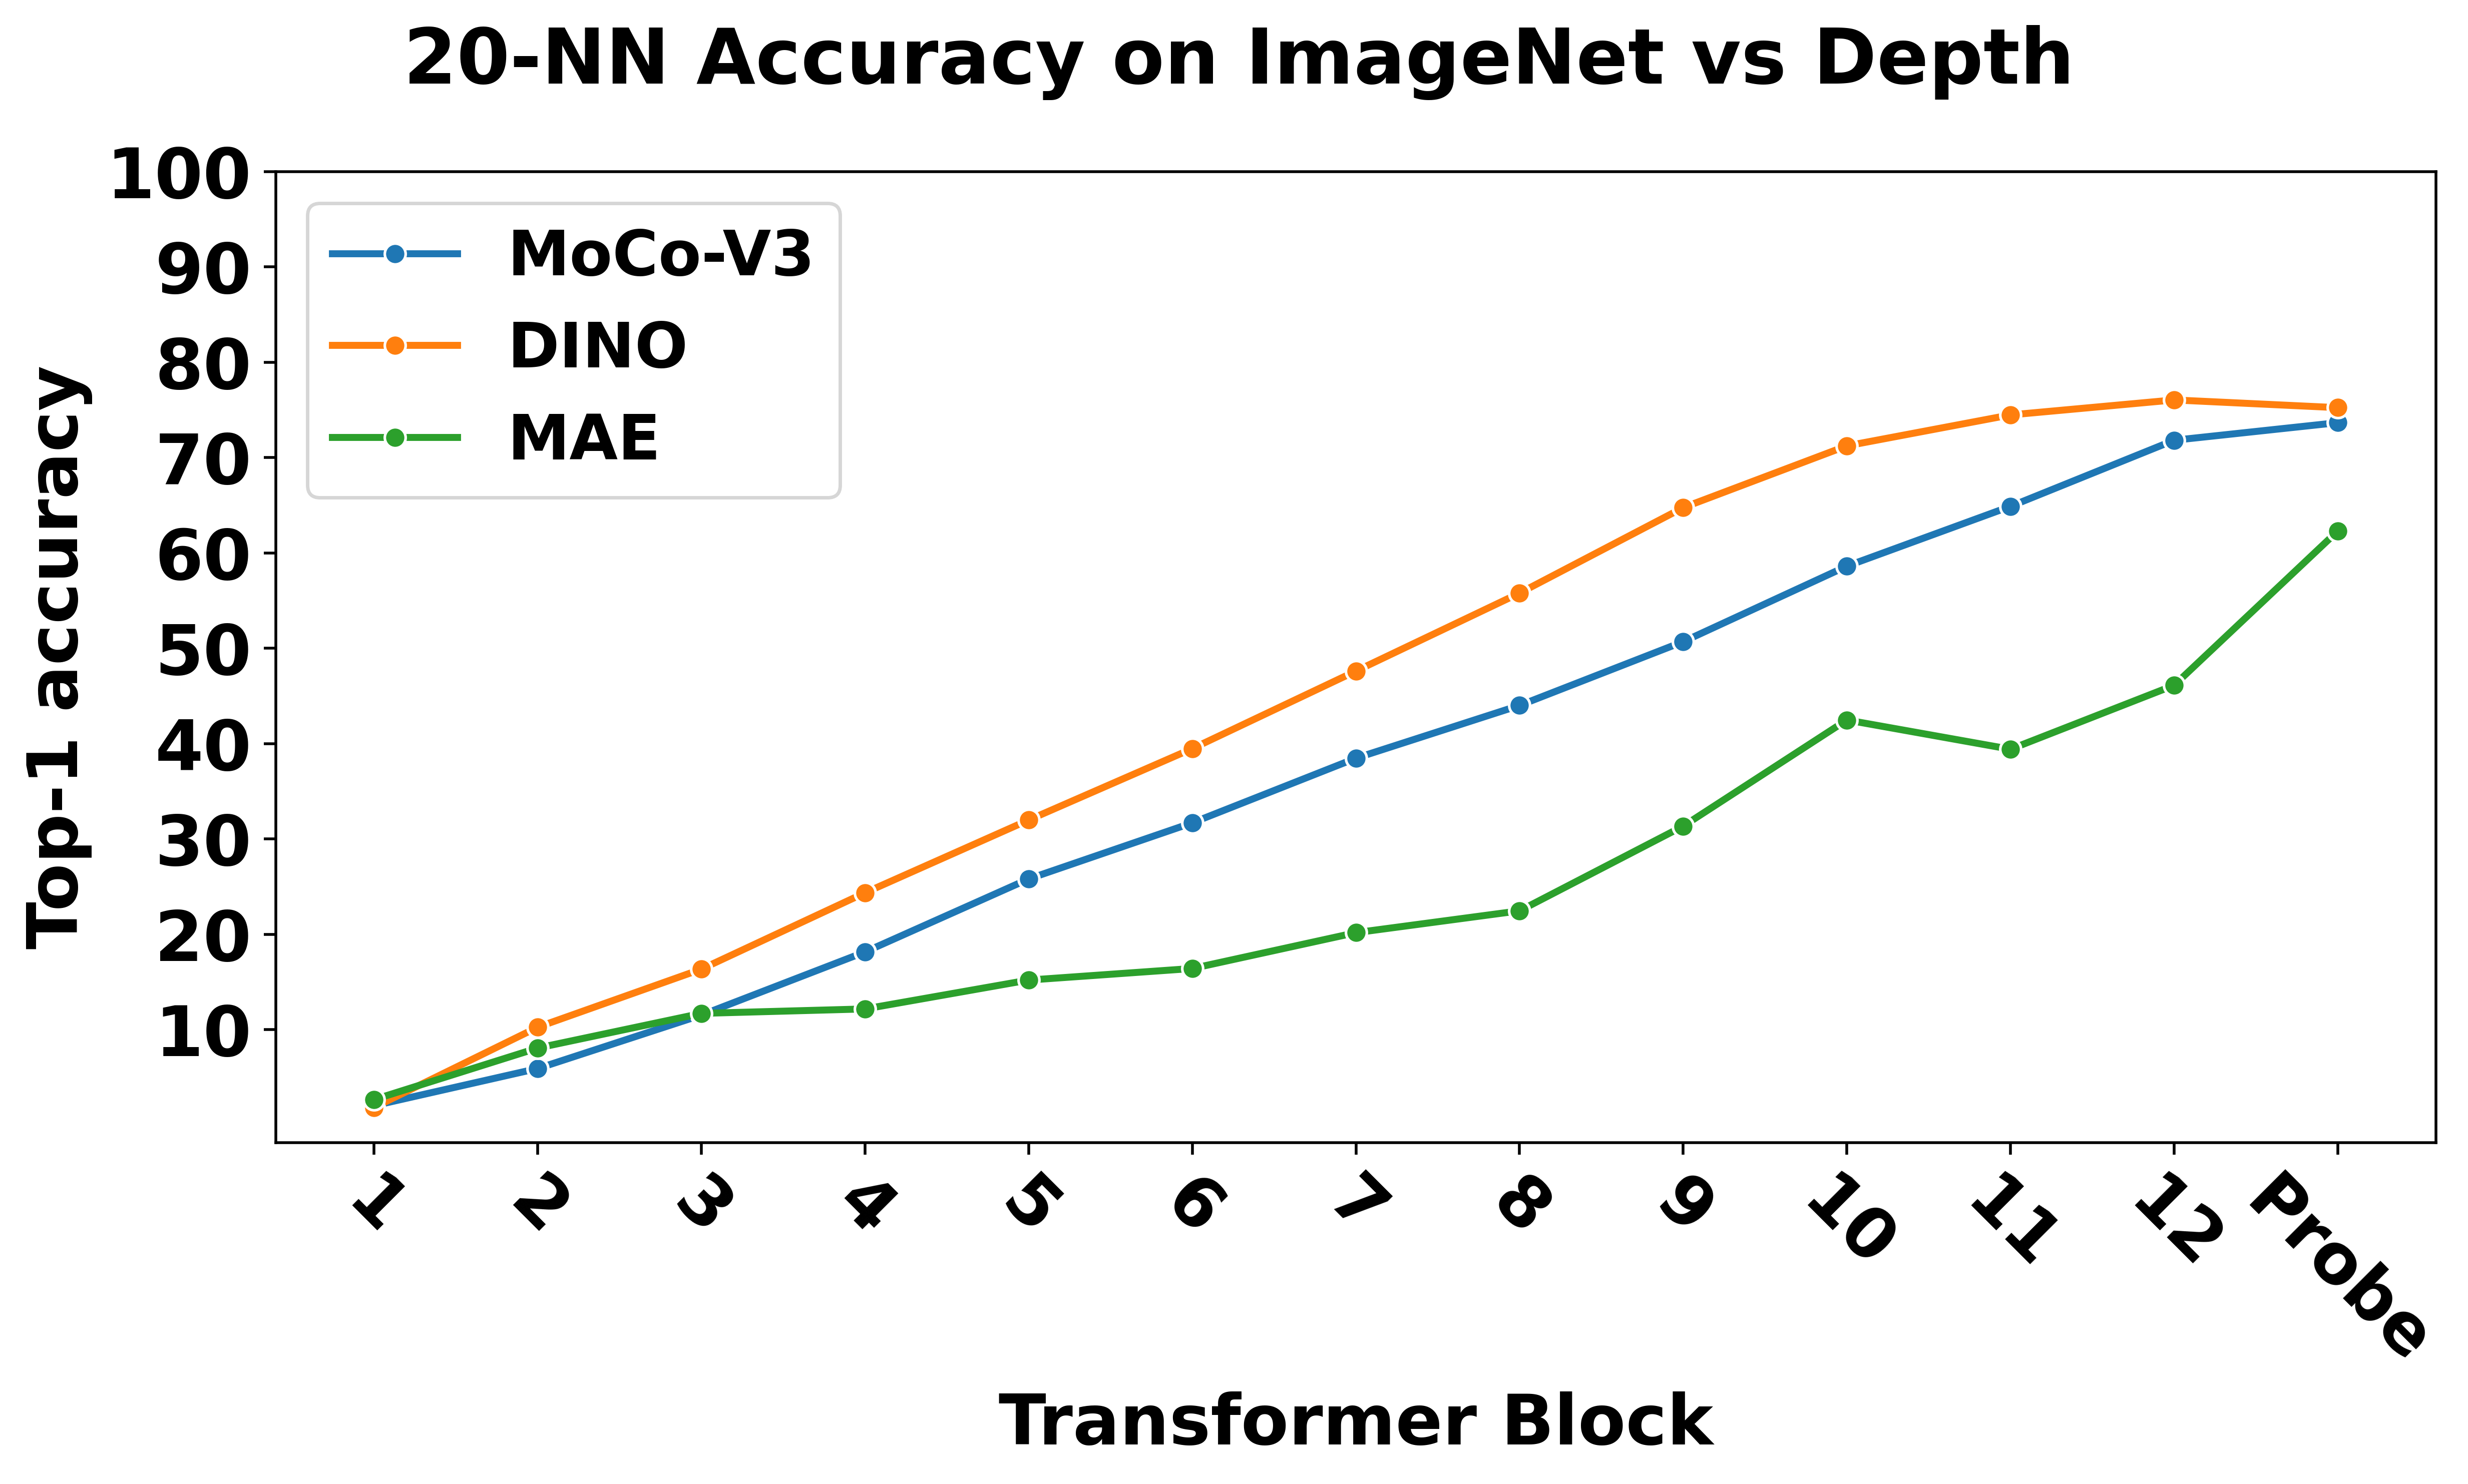

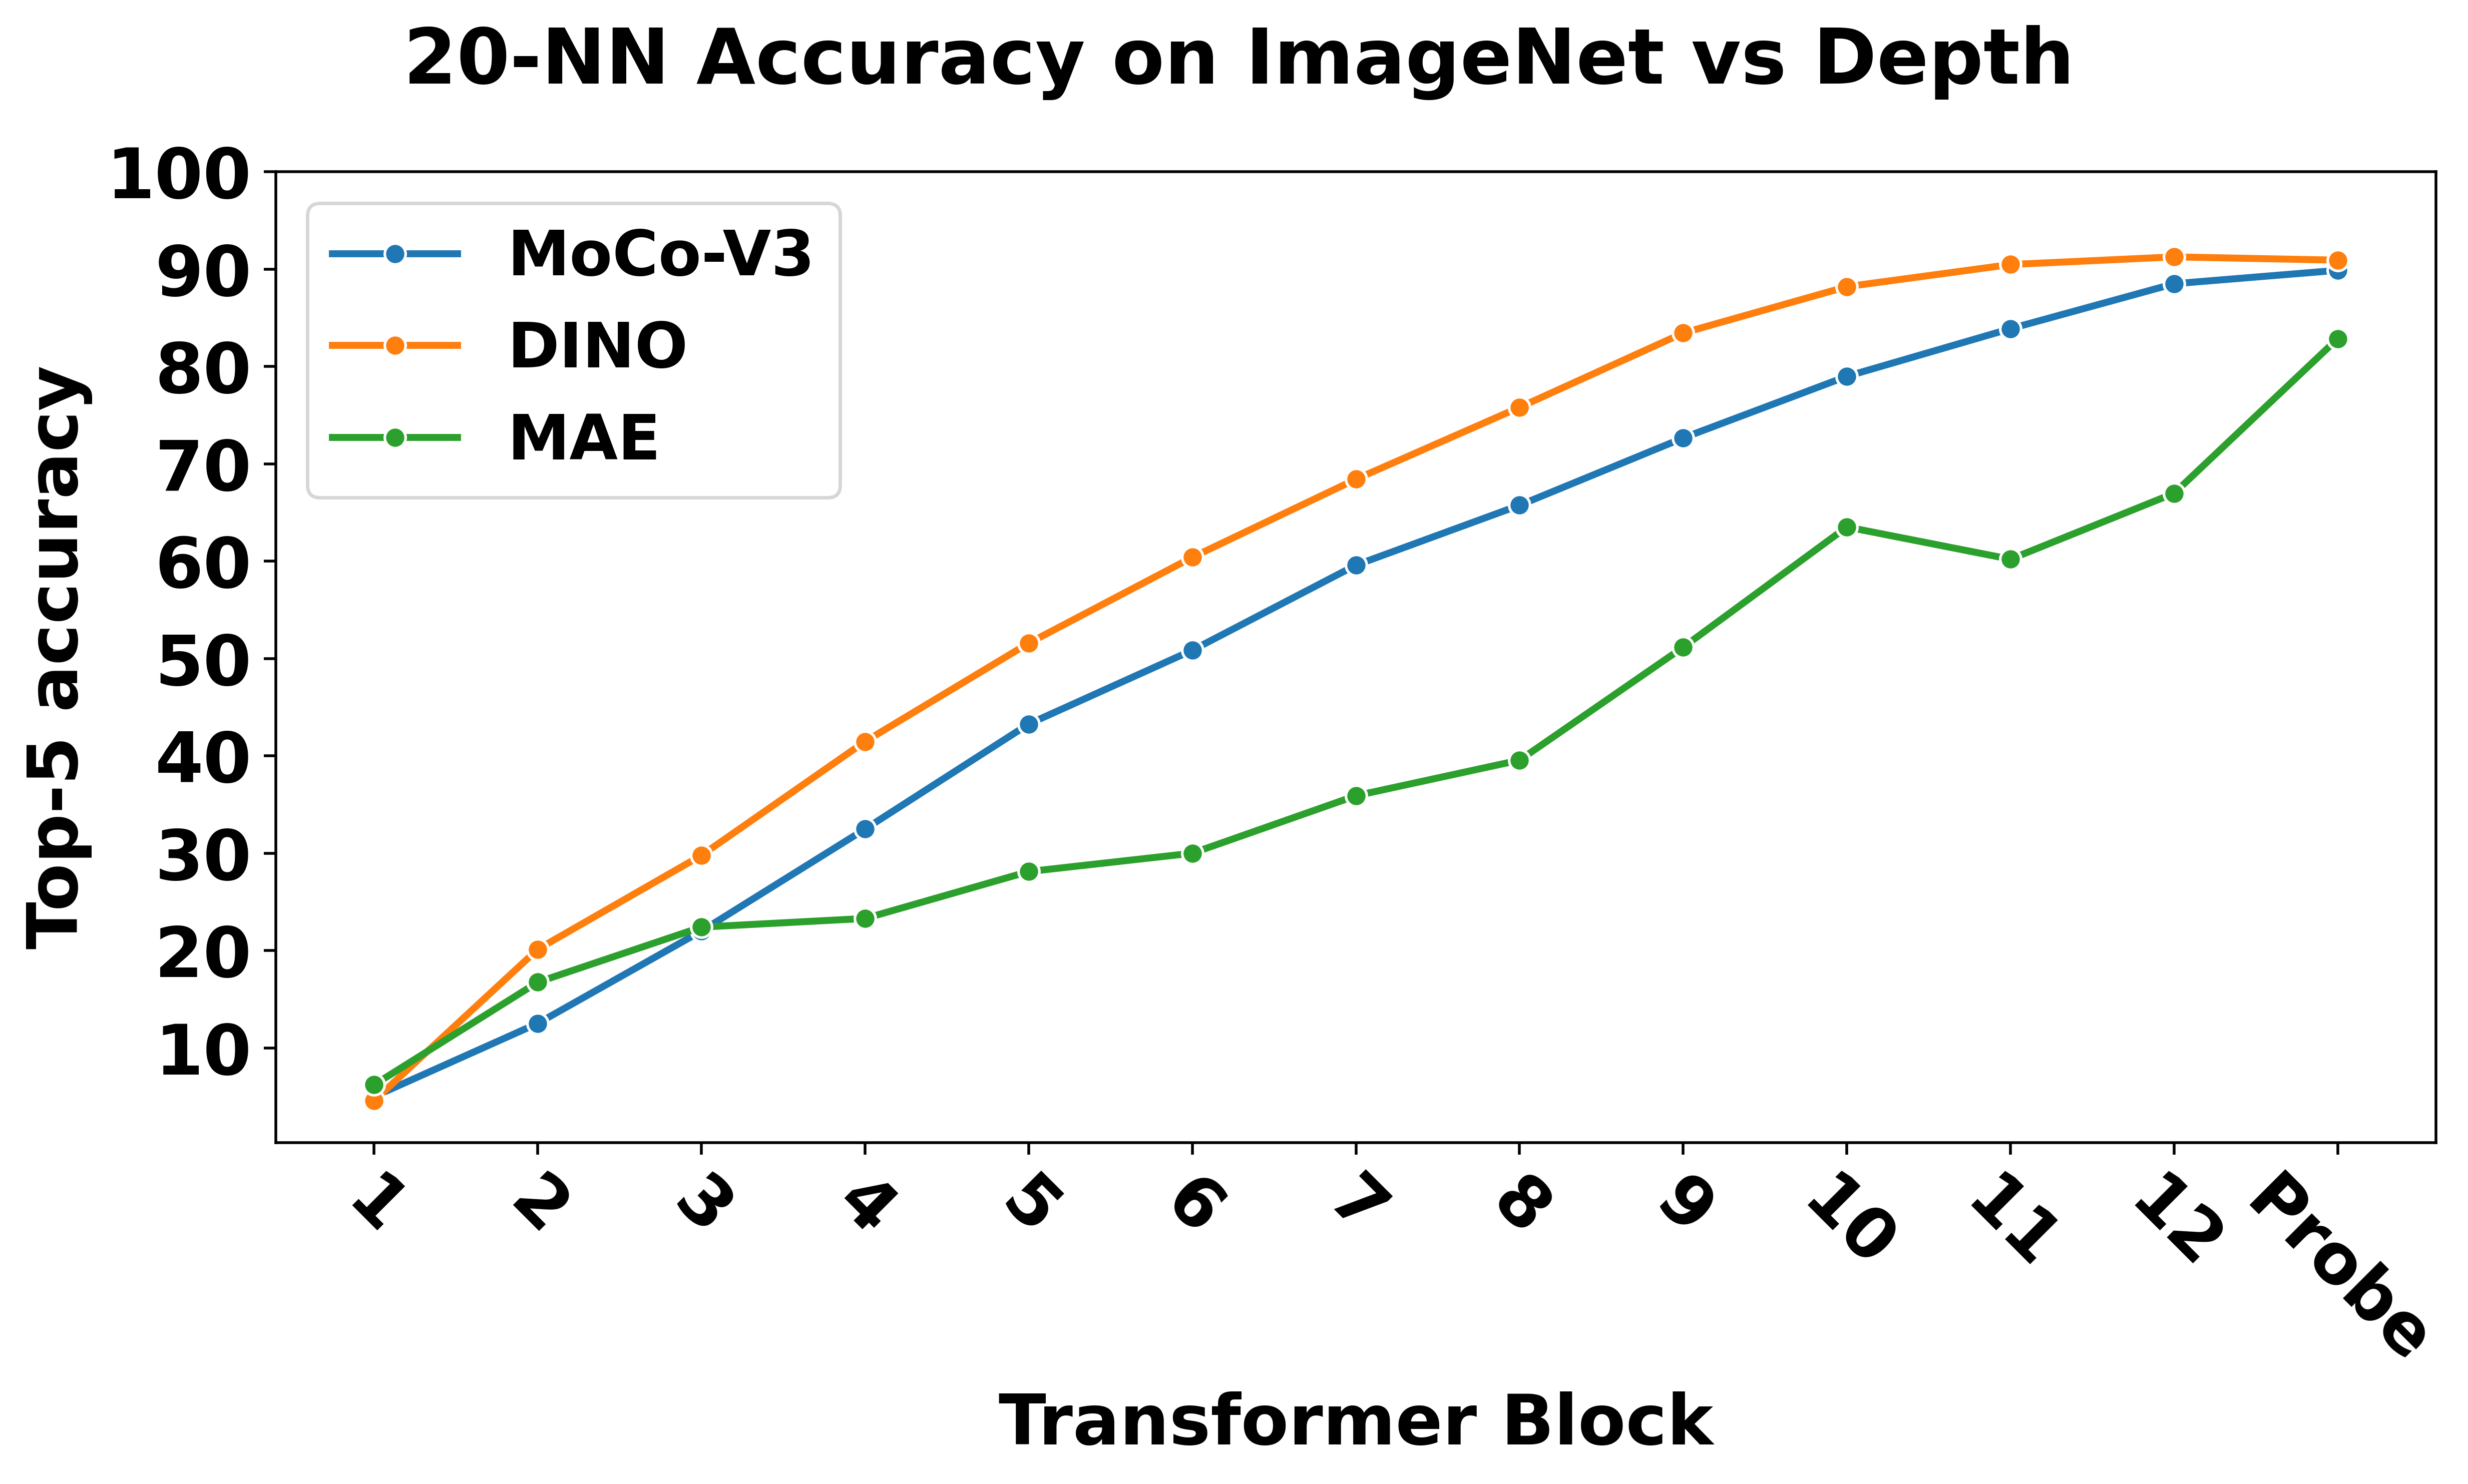

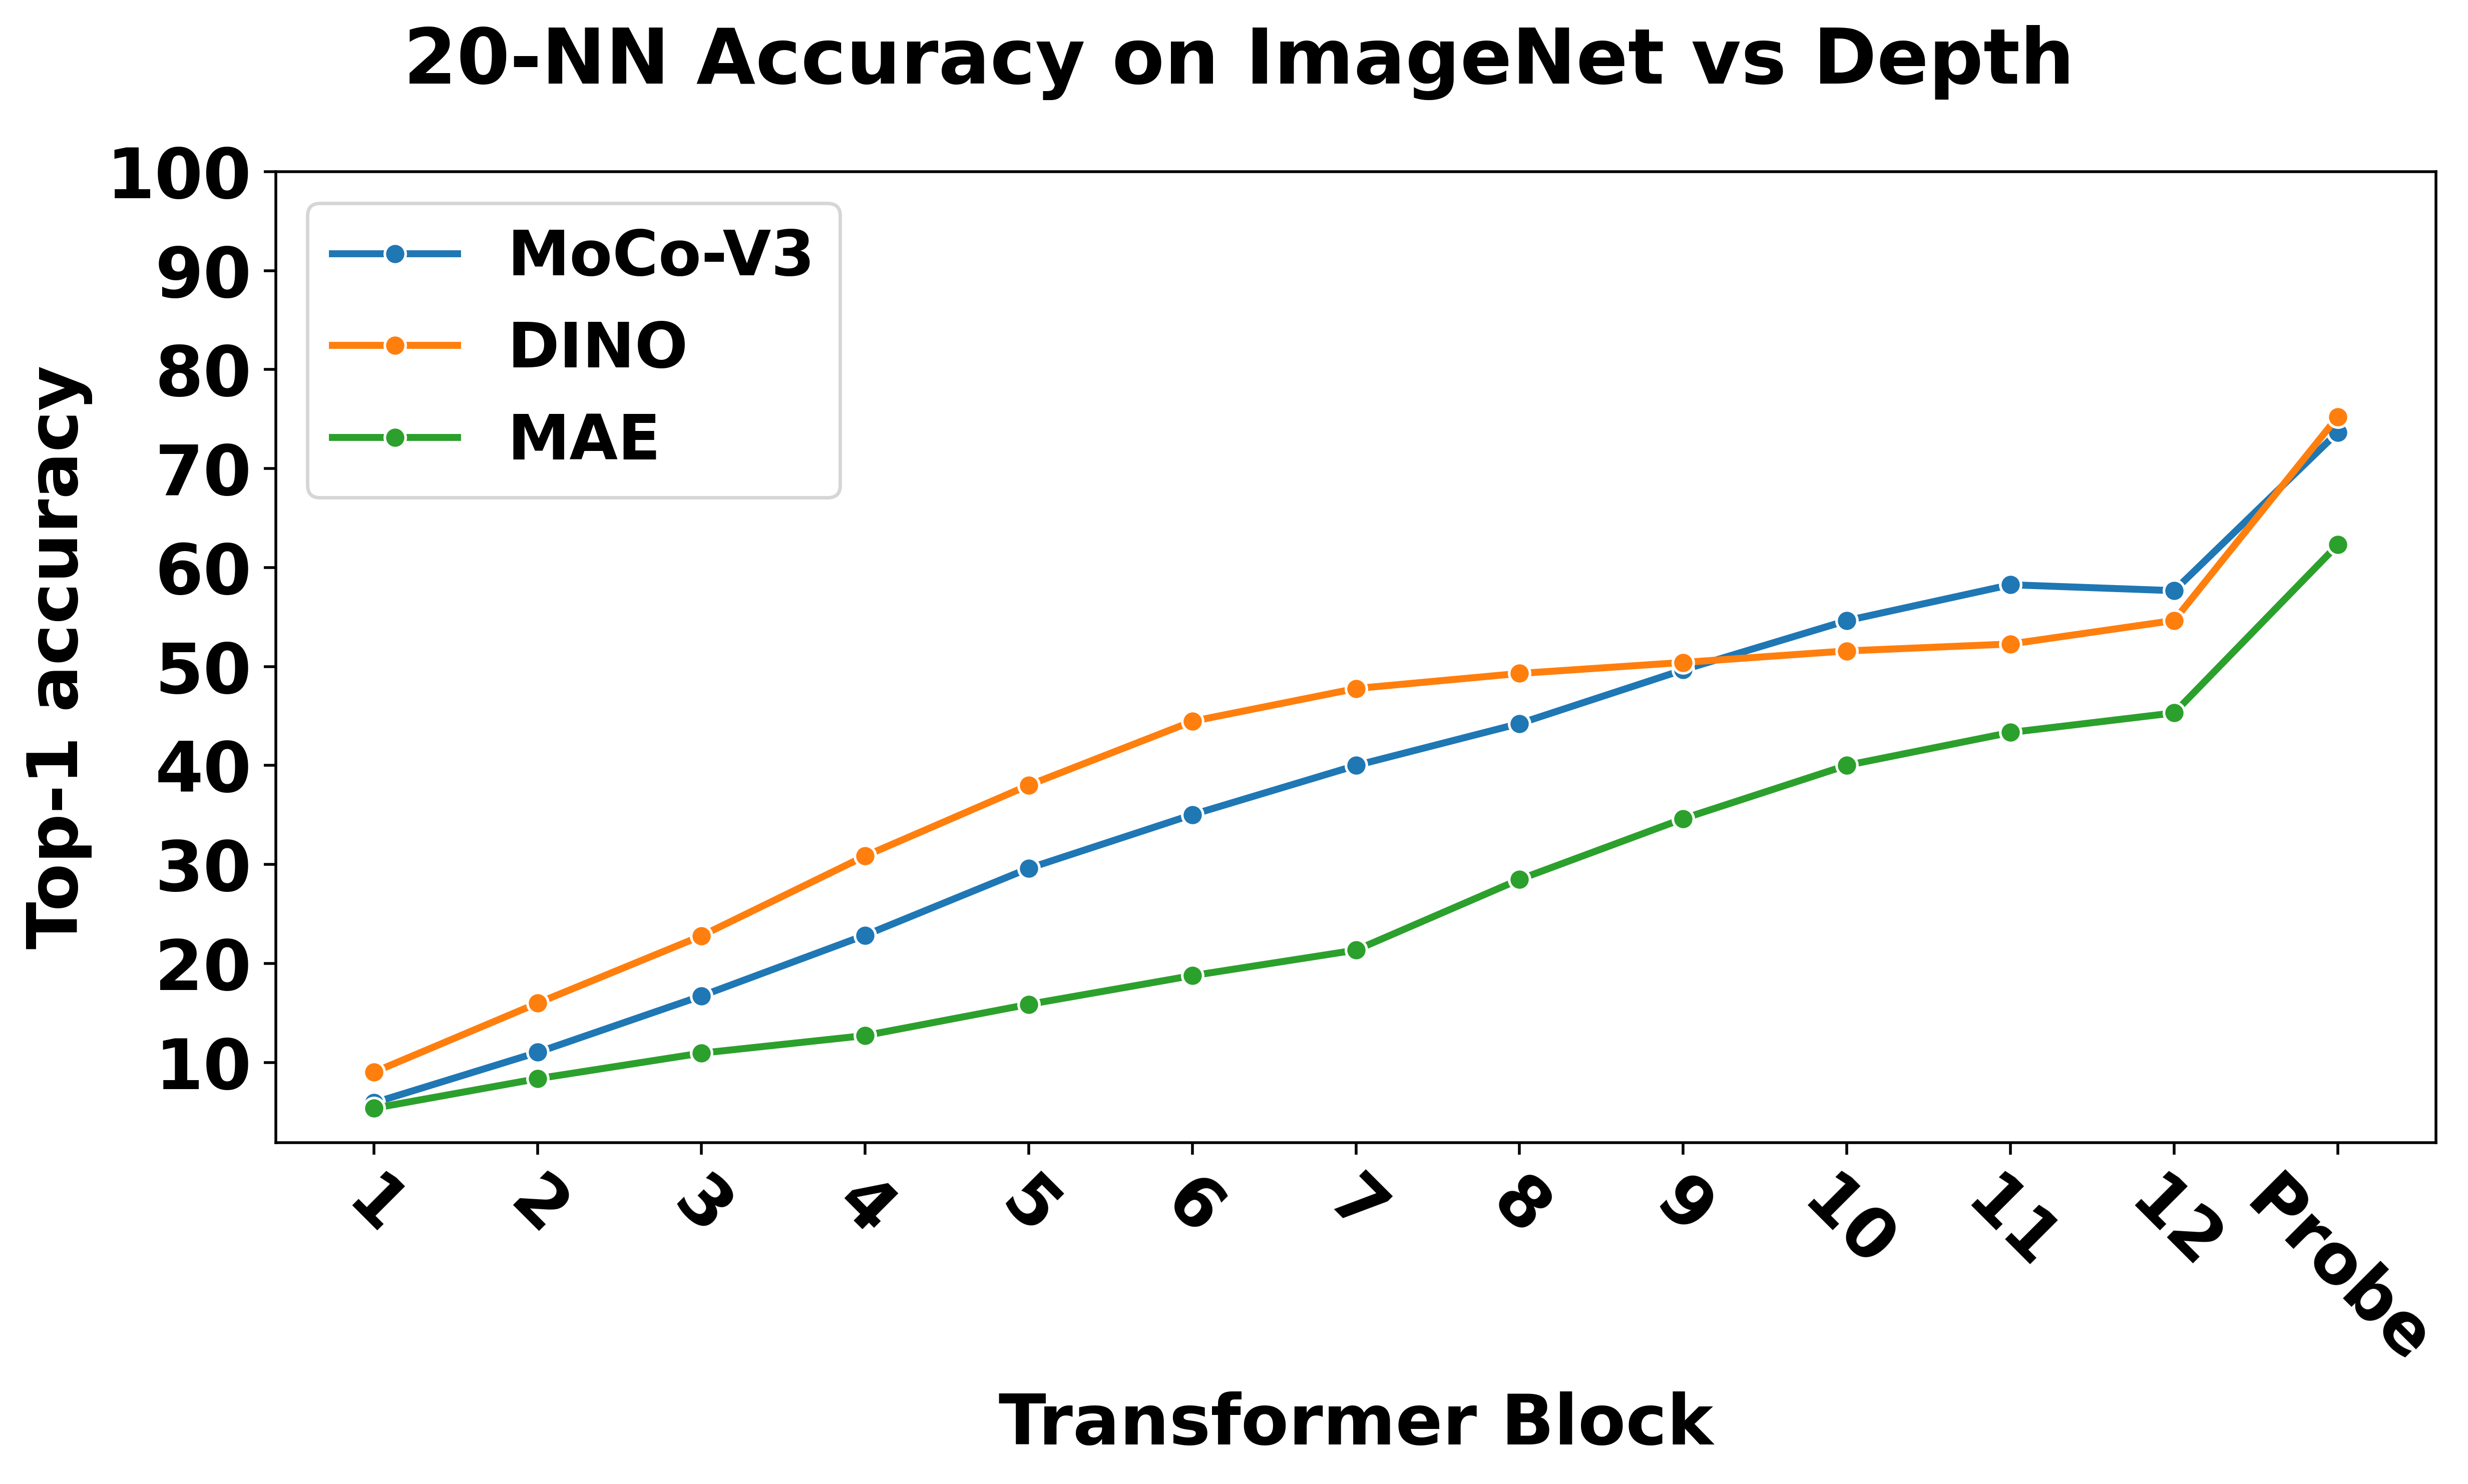

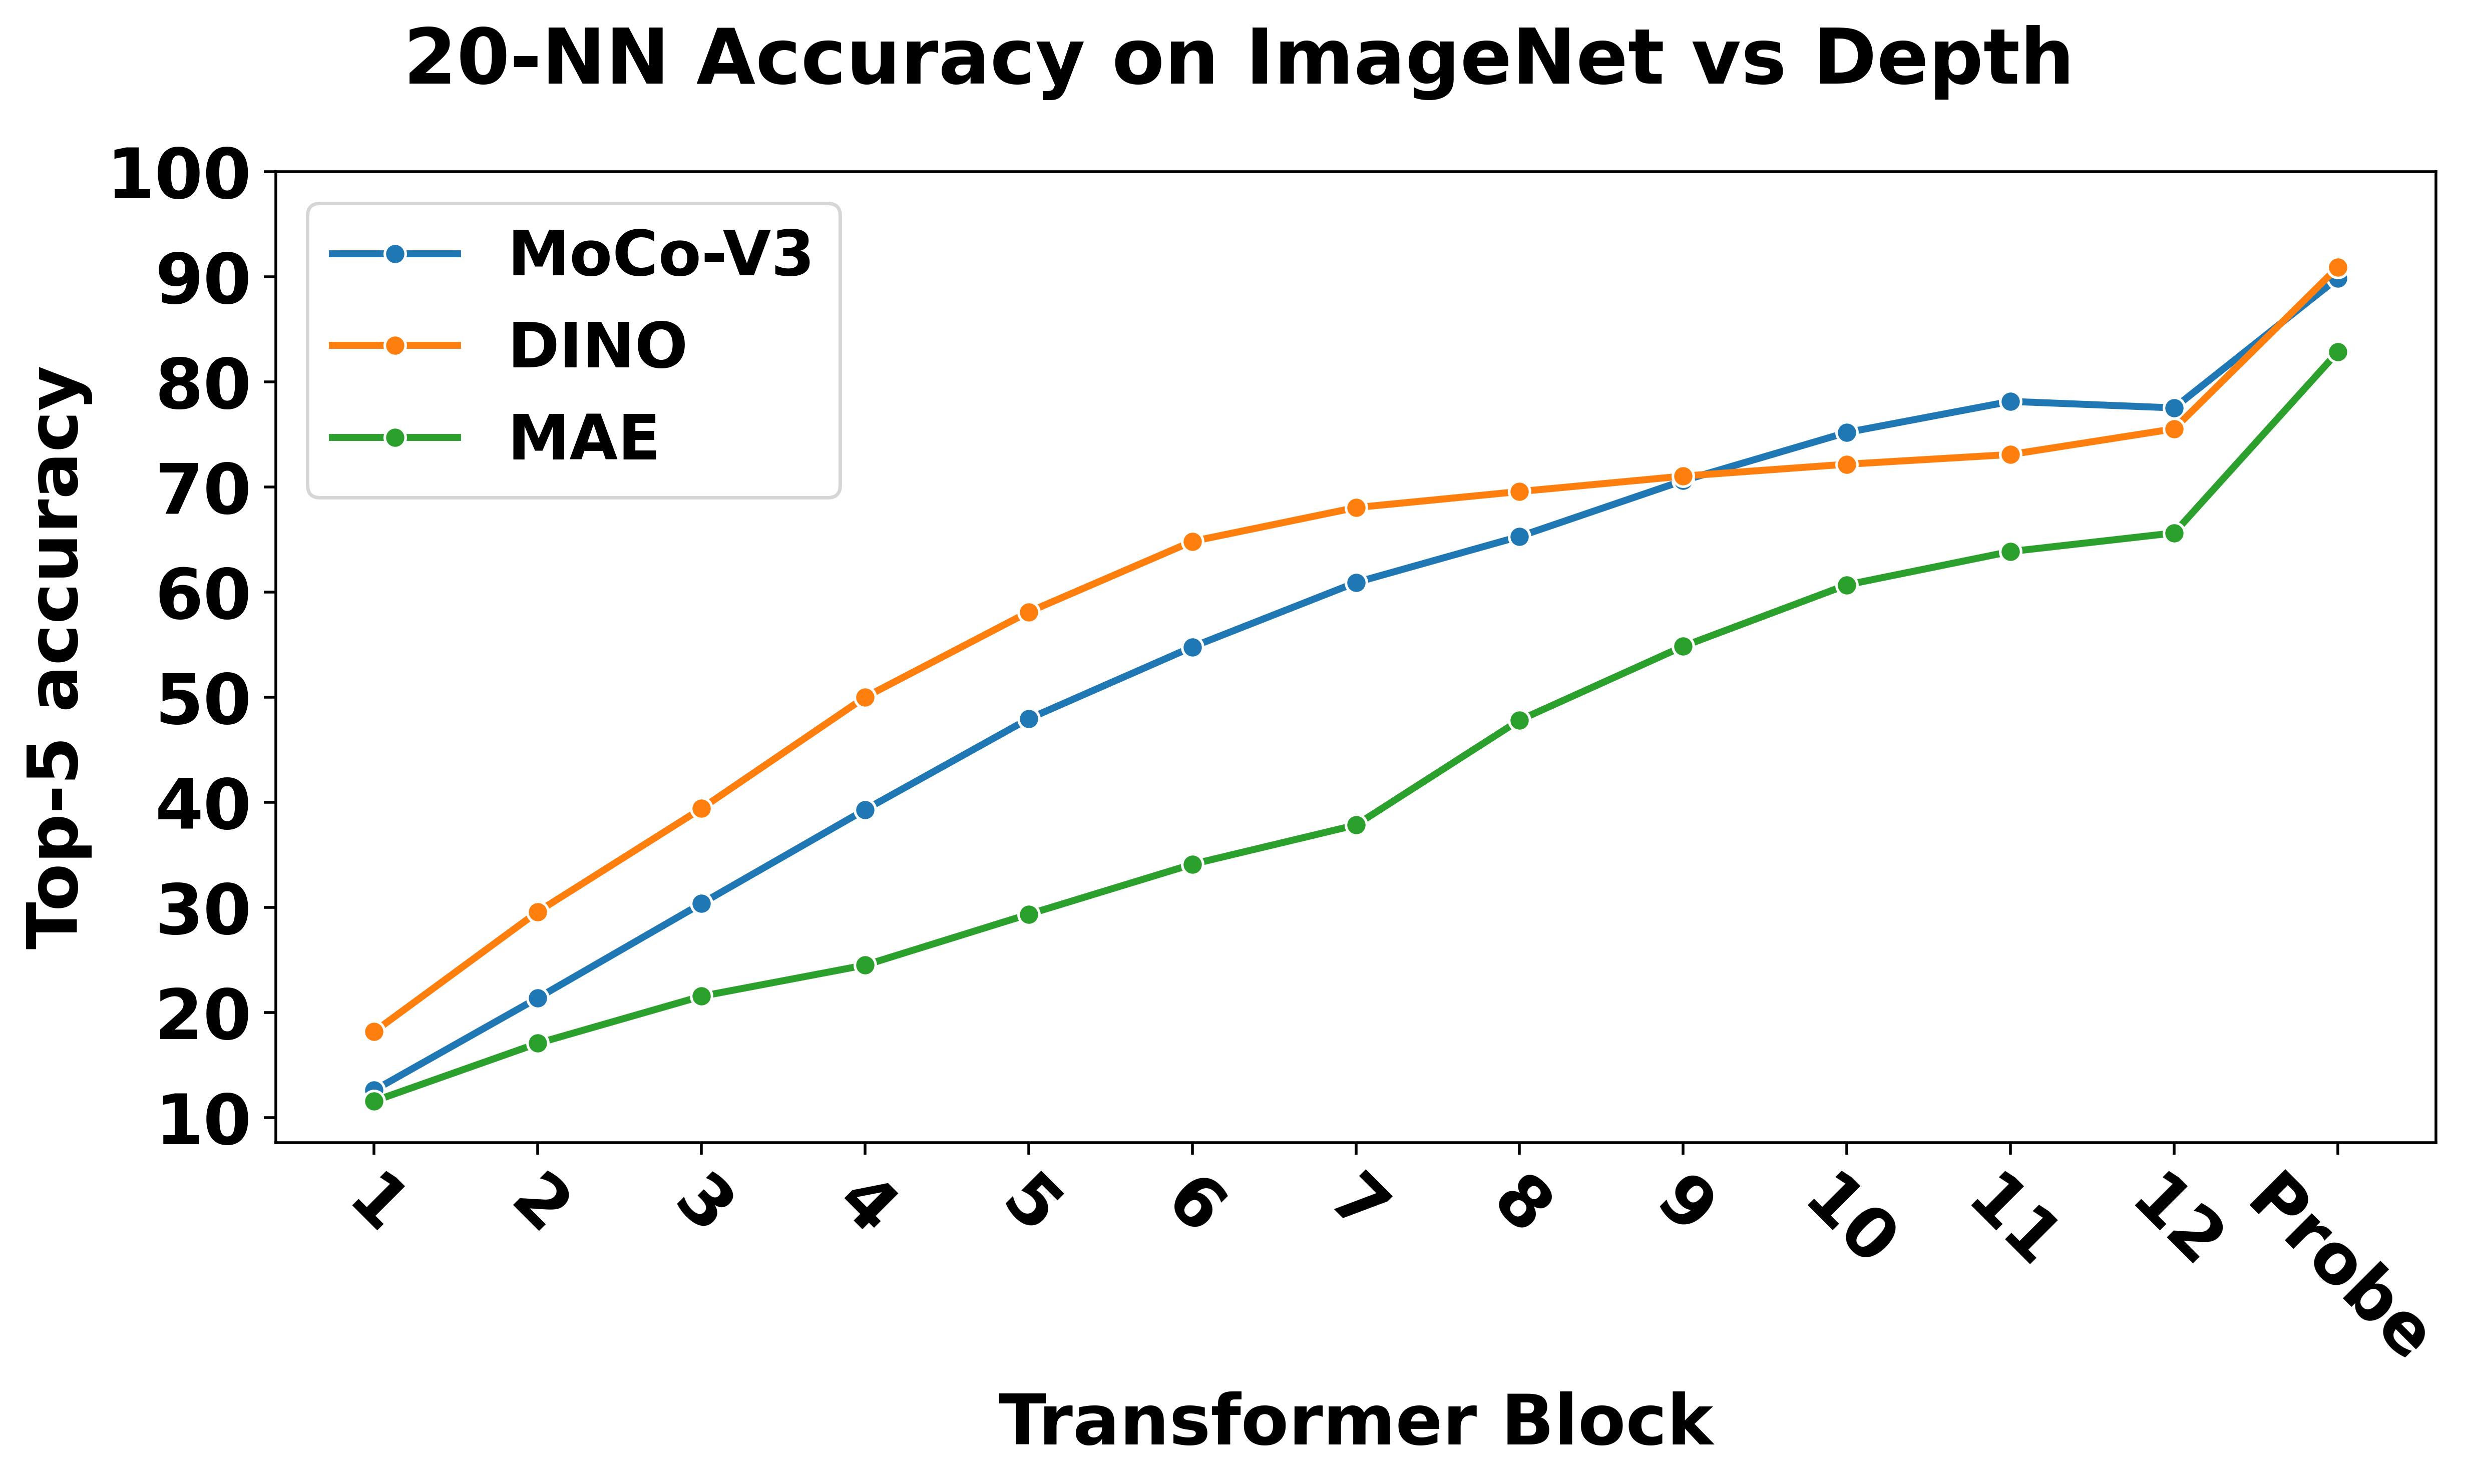

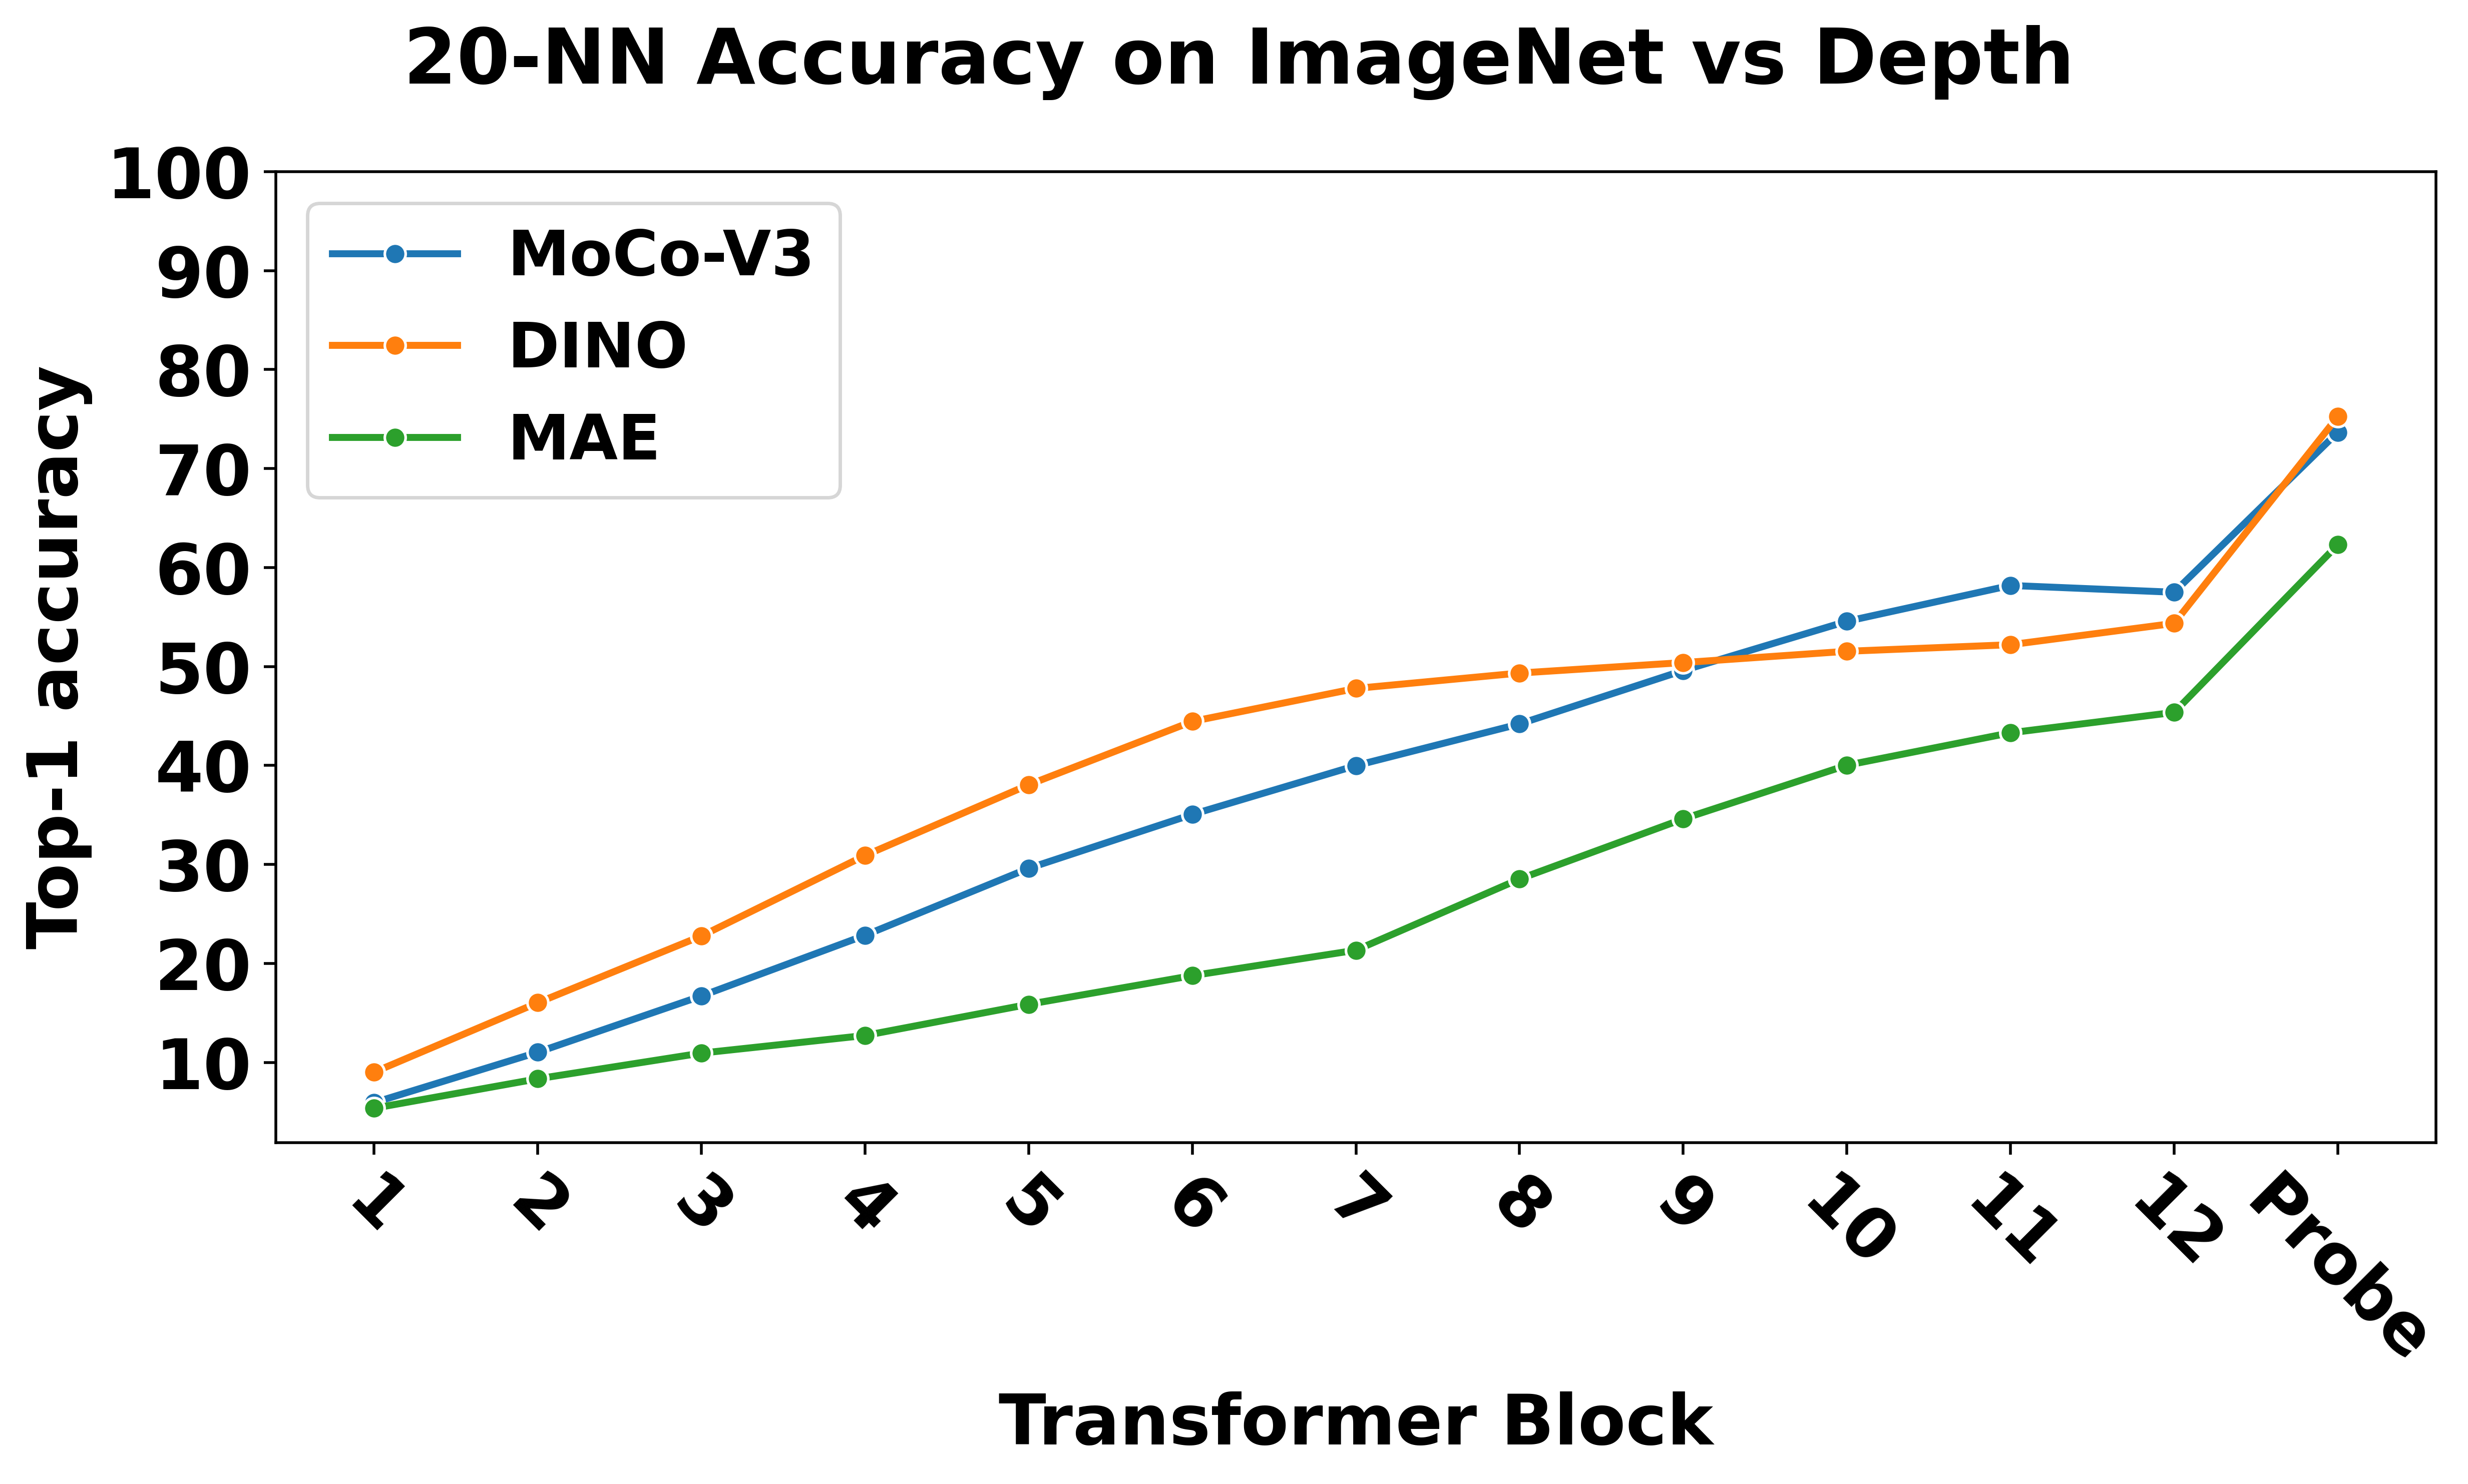

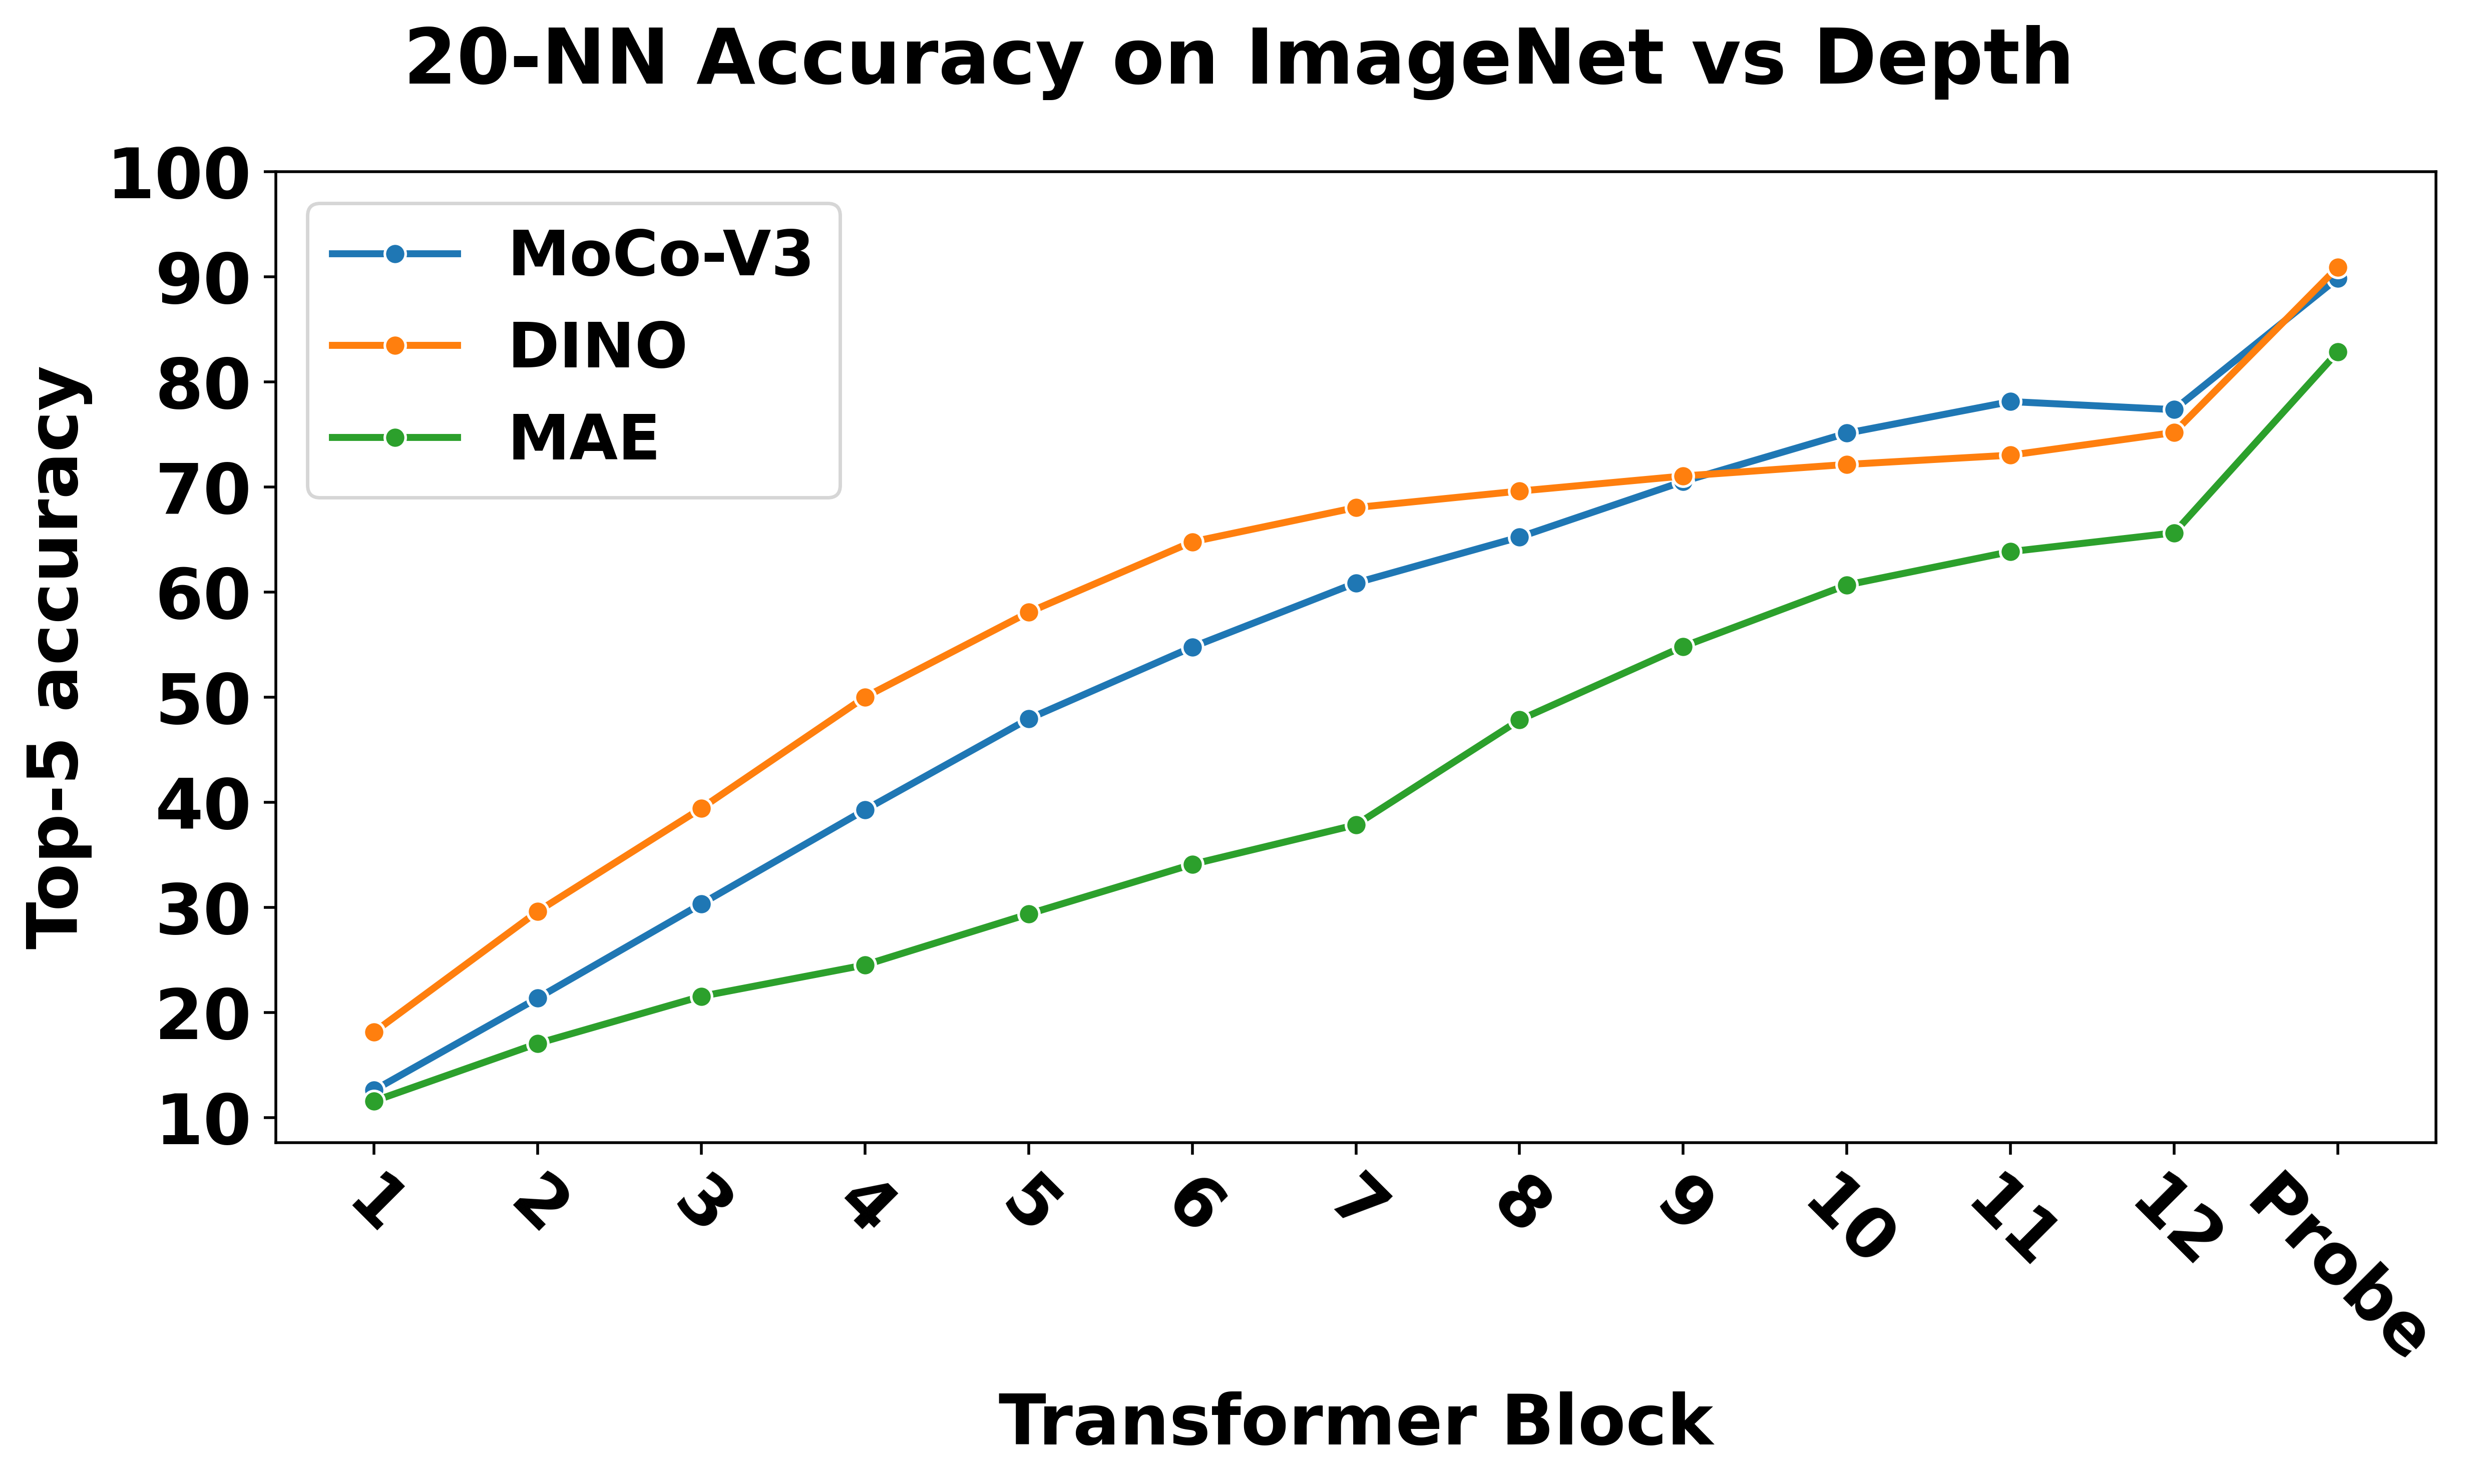

In [31]:
for agg_mode in ['CLS_feats', 'GAP_feats', 'GAP_WO_CLS_feats']:
    for top_n in ['top-1', 'top-5']:
        get_probe_fig_single(results, ['MoCo-V3', 'DINO', 'MAE'], agg_mode, top_n)

In [ ]:
for agg_mode in ['CLS_feats', 'GAP_feats', 'GAP_WO_CLS_feats']:
    for top_n in ['top-1', 'top-5']:
        get_probe_fig_single(results, ['MAE', 'MoCo-V3', 'DINO'], agg_mode, top_n)
        get_probe_figs(results, ['MAE', 'MoCo-V3', 'DINO'], agg_mode, top_n)